## Convolutional Autoencoder initial exploration

Comenzamos entrenando un Autoencoder convolucional (CAE) muy sencillo con datos estandarizados y normalizados -generados en 2.0-, para ver cuáles son más adecuados para nuestro problema

Importamos las librerías necesarias y cargamos los datos

In [1]:
import pickle
import os

from matplotlib import pyplot as plt 
import numpy as np
import tensorflow as tf
from tensorflow.keras import losses

from src.data.create_data import load_data
from src.models.convolutional_autoencoder import ConvAutoencoder
from src.models.variational_autoencoder import VariationalAutoencoder
from src.visualization.visualize import plot_polarization_signature, plot_history

2023-01-31 16:16:44.775223: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-31 16:16:45.593211: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.2/lib64:
2023-01-31 16:16:45.593321: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.2/lib64:
2023-01-31 16:16:45.593330: W tensorflow/compiler/tf2tensorrt/utils/py_uti

In [2]:
# Datos estandarizados con robust scaler
rs_train_filename = "processed/spm_signatures_r_scale_train_set"
rs_test_filename = "processed/spm_signatures_r_scale_test_set"

rscaled_train = load_data(rs_train_filename)
rscaled_test = load_data(rs_test_filename)

# Datos estandarizados con minmax scaler
mm_train_filename = "processed/spm_signatures_m_scale_train_set"
mm_test_filename = "processed/spm_signatures_m_scale_test_set"

mscaled_train = load_data(mm_train_filename)
mscaled_test = load_data(mm_test_filename)

Creamos un CAE sencillo, de una sola capa convolucional tres capas densas, siendo la del centro la correspondiente al espacio latente, al que vamos a darle dimensión 10 para comenzar.

In [3]:
# Configuracion de las capas 
conv_layer_config=dict(
    layers_config=[(4, (3, 4), 2), (4, (3, 3), 1)],
    activation="relu",
    kernel_initializer="glorot_uniform"
    )

dense_layer_config=dict(
    layers_units=(32,),
    activation="relu"
)    

# Espacio Latente y dimensiones de los datos
latent_dimension = 10
input_shape = rscaled_train.shape[1:]

In [4]:
# Inicializo un cae con la configuracion deseada
simple_cae_robust = ConvAutoencoder(
    latent_dimension, 
    input_shape,
    conv_layers=conv_layer_config,
    dense_layers=dense_layer_config
    )  

Entrenamos primero con los datos escaleados con robust scaler

In [4]:
# Chequamos que la GPU está disponible
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

<AxesSubplot:title={'center':'Model train history'}, xlabel='Epochs', ylabel='Mean Absolute Error'>

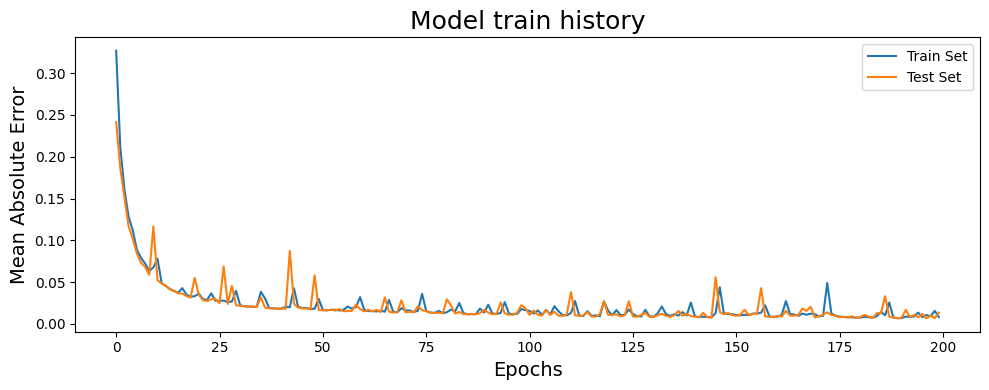

In [6]:
# Compilamos y ajustamos nuestro modelo con los datos estandarizados
simple_cae_robust.compile(optimizer='adam', loss=losses.MeanSquaredError(),
                    metrics=['mean_absolute_error', 'mean_squared_error'])

history = simple_cae_robust.fit(
    rscaled_train, 
    rscaled_train,
    epochs = 200,
    batch_size = 32,
    verbose = 0,
    validation_data=(rscaled_test, rscaled_test)
    )

plot_history(history)

Veamos como reconstruye este modelo algunas imagenes del set de testeo, elegidas al azar

In [ ]:
# Genero y decodifico imagenes de testeo
encoded_imgs = simple_cae_robust.encoder(rscaled_test[:1000]).numpy()
decoded_imgs = simple_cae_robust.decoder(encoded_imgs).numpy()

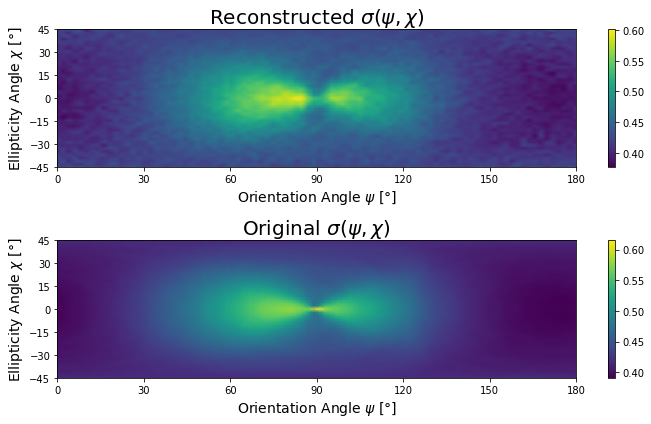

In [ ]:
# Elegimos ana firma al azar
rng = np.random.default_rng()
rnd_index = rng.integers(decoded_imgs.shape[0])
rnd_reconstruct_signature = decoded_imgs[rnd_index, :, :, 0]
rnd_signature = rscaled_test[rnd_index, :, :, 0]

# Ploteamos
fig, ax = plt.subplots(2, 1)

plot_polarization_signature(rnd_reconstruct_signature, ax=ax[0])
plot_polarization_signature(rnd_signature, ax=ax[1])

ax[0].set_title(r'Reconstructed $\sigma(\psi,\chi)$', fontsize = 20)
ax[1].set_title(r'Original $\sigma(\psi,\chi)$', fontsize = 20)

fig.tight_layout()

Eliminamos el modelo, limpiamos el grafo de TensorFlow, y volvemos a entrenar pero esta vez con los datos normalizados con MinMax.

In [7]:
tf.keras.backend.clear_session()
del simple_cae_robust

In [13]:
# Volvemos a generar un cae
simple_cae_norm = ConvAutoencoder(
    latent_dimension, 
    input_shape,
    conv_layers=conv_layer_config,
    dense_layers=dense_layer_config
    )  

In [14]:
# Compilamos y ajustamos nuestro modelo con los datos normalizados
simple_cae_norm.compile(optimizer='adam', loss=losses.MeanSquaredError(),
                    metrics=['mean_absolute_error', 'mean_squared_error'])

history = simple_cae_norm.fit(
    mscaled_train, 
    mscaled_train,
    epochs = 200,
    batch_size = 32,
    verbose = 0,
    validation_data=(rscaled_test, rscaled_test)
    )

<AxesSubplot:title={'center':'Model train history'}, xlabel='Epochs', ylabel='Mean Absolute Error'>

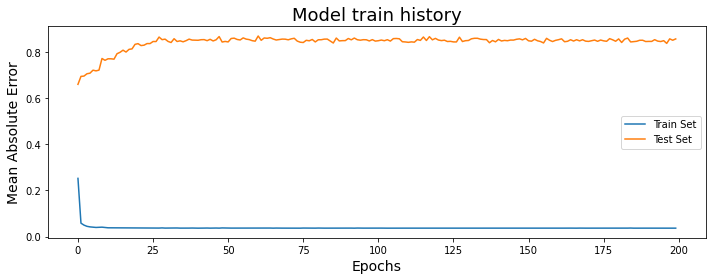

In [15]:
fig, ax = plt.subplots(1, 1)
plot_history(history, ax=ax)

Como vemos, no hace falta observar la recontrucción de los datos para concluir que con datos normalizados, el cae no mejora su performance a medida que transcurre el entrenamiento. Por lo tanto descartamos este enfoque.

In [16]:
tf.keras.backend.clear_session()
del simple_cae_norm

### Prueba con Robust Scaler 1 feature

In [5]:
from src.features.preprocess_data import RScaler_beta
# Datos estandarizados con robust scaler
beta_train_filename="processed/spm_signatures_beta_scale_train_set"
beta_test_filename="processed/spm_signatures_beta_scale_test_set"

beta_scaled_train = load_data(beta_train_filename)
beta_scaled_test = load_data(beta_test_filename)

In [6]:
input_shape = beta_scaled_train.shape[1:]
# Inicializo un cae con la configuracion deseada
simple_cae_beta = ConvAutoencoder(
    latent_dimension, 
    input_shape,
    conv_layers=conv_layer_config,
    dense_layers=dense_layer_config
    )  

<AxesSubplot:title={'center':'Model train history'}, xlabel='Epochs', ylabel='Mean Absolute Error'>

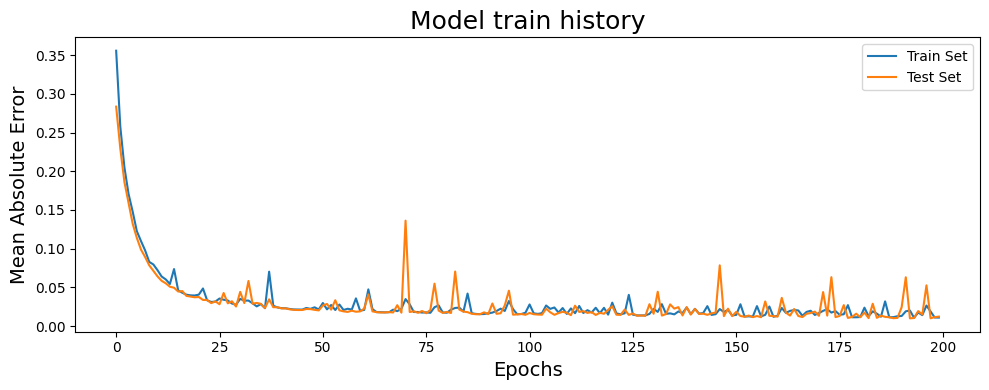

In [7]:
# Compilamos y ajustamos nuestro modelo con los datos estandarizados
simple_cae_beta.compile(optimizer='adam', loss=losses.MeanSquaredError(),
                    metrics=['mean_absolute_error', 'mean_squared_error'])

history = simple_cae_beta.fit(
    beta_scaled_train, 
    beta_scaled_train,
    epochs = 200,
    batch_size = 32,
    verbose = 0,
    validation_data=(beta_scaled_test, beta_scaled_test)
    )

plot_history(history)

Veamos como reconstruye este modelo algunas imagenes del set de testeo, elegidas al azar

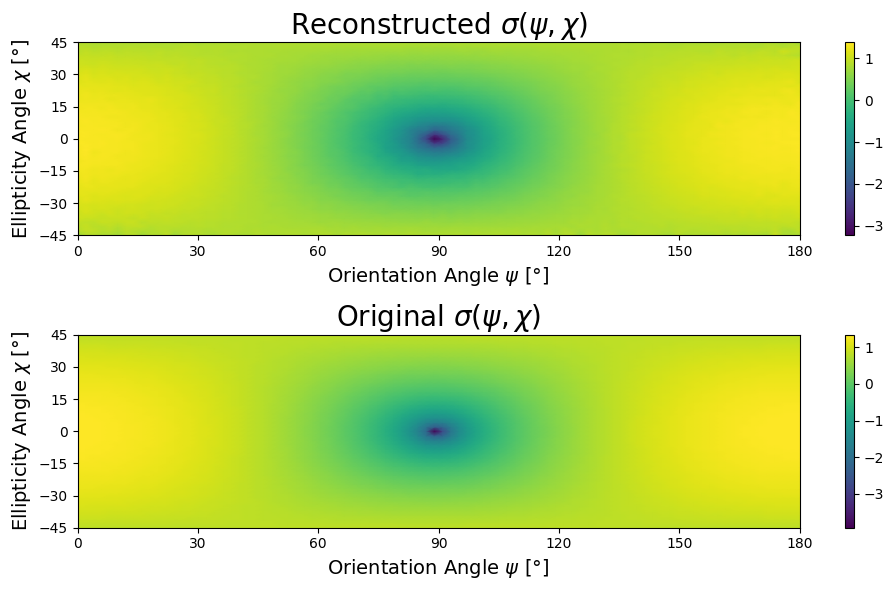

In [8]:
# Genero y decodifico imagenes de testeo
encoded_imgs = simple_cae_beta.encoder(beta_scaled_test).numpy()
decoded_imgs = simple_cae_beta.decoder(encoded_imgs).numpy()

# Elegimos ana firma al azar
rng = np.random.default_rng()
rnd_index = rng.integers(decoded_imgs.shape[0])
rnd_reconstruct_signature = decoded_imgs[rnd_index, :, :, 0]
rnd_signature = beta_scaled_test[rnd_index, :, :, 0]

# Ploteamos
fig, ax = plt.subplots(2, 1)

plot_polarization_signature(rnd_reconstruct_signature, ax=ax[0])
plot_polarization_signature(rnd_signature, ax=ax[1])

ax[0].set_title(r'Reconstructed $\sigma(\psi,\chi)$', fontsize = 20)
ax[1].set_title(r'Original $\sigma(\psi,\chi)$', fontsize = 20)

fig.tight_layout()

In [9]:
sigma_shape = rnd_signature.shape
size = sigma_shape[0]*sigma_shape[1]

reconstruction_error = np.sum((rnd_signature - rnd_reconstruct_signature)**2)/size
print(reconstruction_error)

0.0005769803054595135


Veamos si mejora la reconstrucción agregando un termino sparsity a la función de costo. Para ello simplemento agregamos el keyword sparse=True al constructor del CAE. 

In [10]:
input_shape = beta_scaled_train.shape[1:]
# Inicializo un cae con la configuracion deseada
sparse_cae = ConvAutoencoder(
    latent_dimension, 
    input_shape,
    conv_layers=conv_layer_config,
    dense_layers=dense_layer_config,
    sparse=True
    )  

<AxesSubplot:title={'center':'Model train history'}, xlabel='Epochs', ylabel='Mean Absolute Error'>

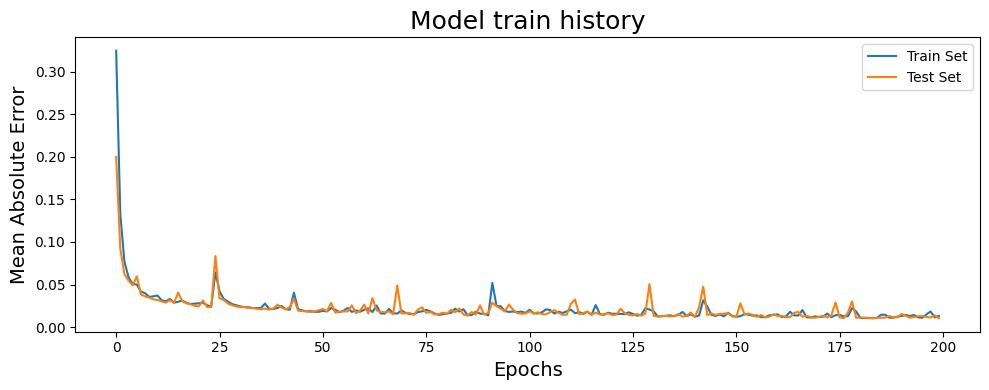

In [11]:
# Compilamos y ajustamos nuestro modelo con los datos estandarizados
sparse_cae.compile(optimizer='adam', loss=losses.MeanSquaredError(),
                    metrics=['mean_absolute_error', 'mean_squared_error'])

history = sparse_cae.fit(
    beta_scaled_train, 
    beta_scaled_train,
    epochs = 200,
    batch_size = 32,
    verbose = 0,
    validation_data=(beta_scaled_test, beta_scaled_test)
    )

plot_history(history)

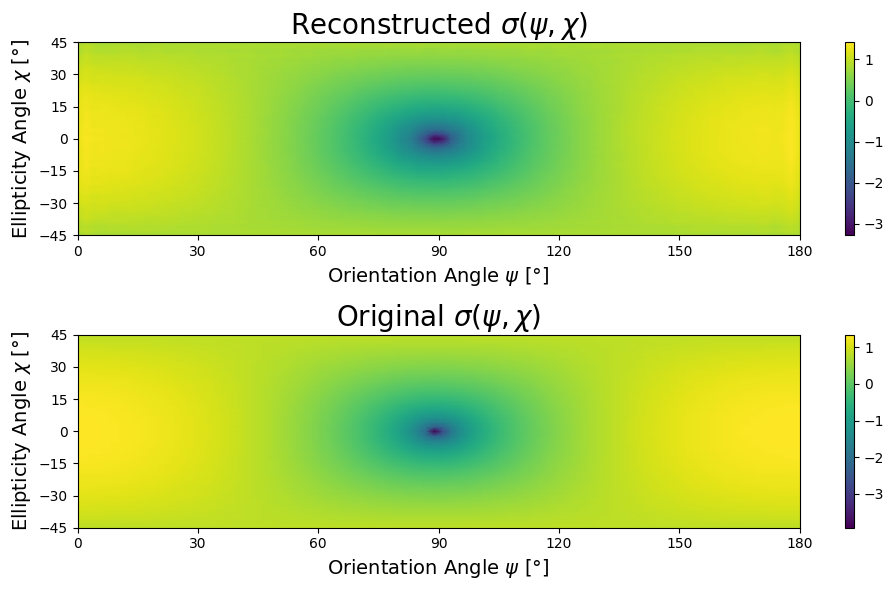

In [12]:
# Genero y decodifico imagenes de testeo
encoded_imgs = sparse_cae.encoder(beta_scaled_test).numpy()
decoded_imgs = sparse_cae.decoder(encoded_imgs).numpy()

# Elegimos ana firma al azar
rnd_reconstruct_signature = decoded_imgs[rnd_index, :, :, 0]
rnd_signature = beta_scaled_test[rnd_index, :, :, 0]

# Ploteamos
fig, ax = plt.subplots(2, 1)

plot_polarization_signature(rnd_reconstruct_signature, ax=ax[0])
plot_polarization_signature(rnd_signature, ax=ax[1])

ax[0].set_title(r'Reconstructed $\sigma(\psi,\chi)$', fontsize = 20)
ax[1].set_title(r'Original $\sigma(\psi,\chi)$', fontsize = 20)

fig.tight_layout()

In [13]:
sigma_shape = rnd_signature.shape
size = sigma_shape[0]*sigma_shape[1]

reconstruction_error = np.sum((rnd_signature - rnd_reconstruct_signature)**2)/size
print(reconstruction_error)

0.0004298738094097321


In [14]:
tf.keras.backend.clear_session()
del sparse_cae, simple_cae_beta

### 3. Variational AutoEncoder

Esta tercer variante del AutoEncoder Convolucional tiene el agregado de tener una representación continua del espacio latente -obtenemos distribuciones en vez de un escalar- que puede ser útil a la hora de visualizar el mismo.

In [15]:
var_cae = VariationalAutoencoder(
    latent_dimension, 
    input_shape,
    conv_layers=conv_layer_config,
    dense_layers=dense_layer_config,
    )  

<AxesSubplot:title={'center':'Model train history'}, xlabel='Epochs', ylabel='Kullback Leiber'>

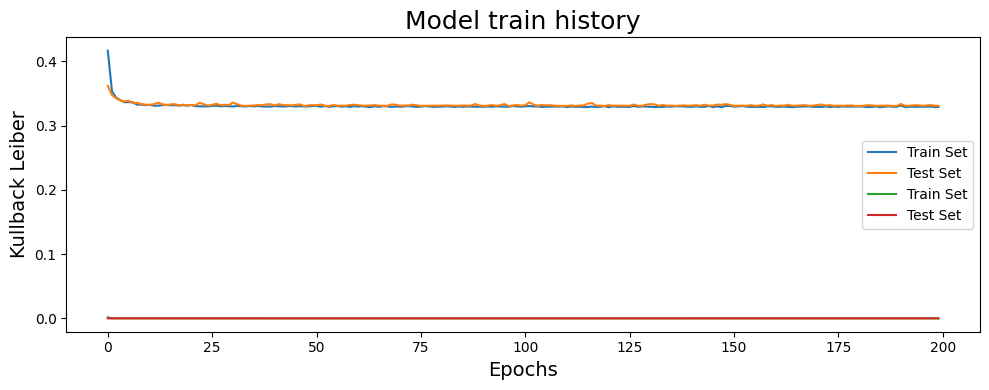

In [16]:
var_cae.compile(optimizer='adam', loss=losses.MeanSquaredError())

history = var_cae.fit(
    beta_scaled_train, 
    beta_scaled_train,
    epochs = 200,
    batch_size = 32,
    verbose = 0,
    validation_data=(beta_scaled_test, beta_scaled_test)
    )

plot_history(history, metric="mean_squared_error")
plot_history(history, metric="kullback_leiber")

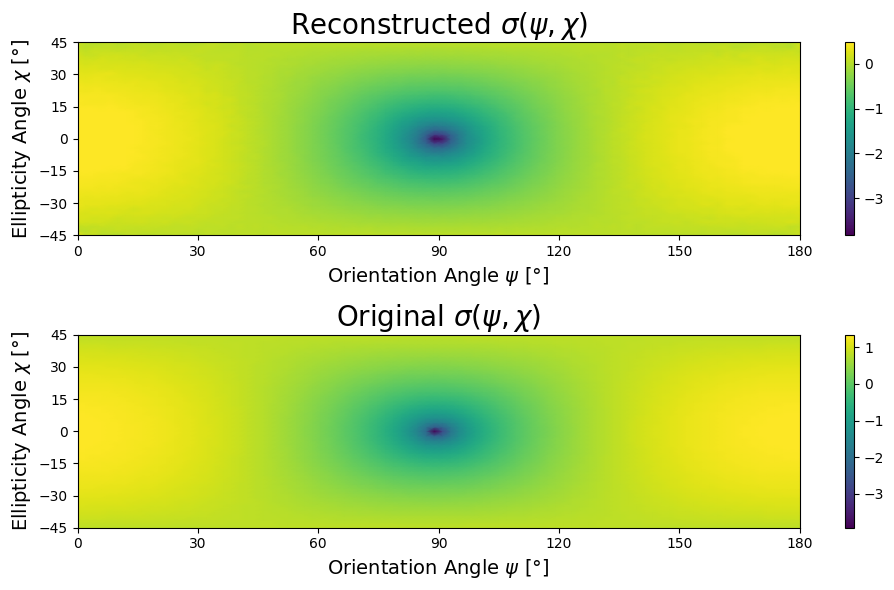

In [17]:
Z = var_cae.encoder(beta_scaled_test)
Z_mean = var_cae._latent_mean(Z)
Z_var = var_cae._latent_log_var(Z)
encoded_imgs = var_cae._sampling(Z_mean, Z_var)
decoded_imgs = var_cae.decoder(encoded_imgs).numpy()

# Elegimos ana firma al azar
rnd_reconstruct_signature = decoded_imgs[rnd_index, :, :, 0]
rnd_signature = beta_scaled_test[rnd_index, :, :, 0]

# Ploteamos
fig, ax = plt.subplots(2, 1)

plot_polarization_signature(rnd_reconstruct_signature, ax=ax[0])
plot_polarization_signature(rnd_signature, ax=ax[1])

ax[0].set_title(r'Reconstructed $\sigma(\psi,\chi)$', fontsize = 20)
ax[1].set_title(r'Original $\sigma(\psi,\chi)$', fontsize = 20)

fig.tight_layout()

In [18]:
reconstruction_error = np.sum((rnd_signature - rnd_reconstruct_signature)**2)/size
print(reconstruction_error)

0.5932610557447504
